# Прочерчивание максимумов Х-структуры -- построение рисунков


Цель -- построить и собрать воедино рисунки (максимумы Х-структуры, графики зависимости углов и интенсивностей от расстояния от центра) для двух случаев: без модели диска и без всей модели (диск + все балджи; т.е. остаток, вычет). Построение для одного случая не предусмотрено. 

Указываются имена галактик в виде списка names = ['name_galaxy_1','name_galaxy_2', ...]. 

Максимумы наносятся на соответствующее изображение галактики (без модели диска или без модели "диск + балдж"), которое берётся из папки images. Имя изображения выглядит так: 'image_{name_galaxy}\_d.fits' или 'image_{name_galaxy}\_m.fits', -- где первое -- без модели диска, второе -- без всей модели (остаток). Например, images/image_name_galaxy_1_m.fits. Исходное изображение (Raw image), на которое ничего не наносится, выглядит как 'image_{name_galaxy}.fits', однако его можно и не рисовать.

Для построения результирующих рисунков берутся данные (angles.dat, coord_xy_peaks.dat, intensities.dat) из папок result/{имя\_папки} (в них находятся все результаты работы скрипта), где {имя\_папки} выглядит как '{name_galaxy}\_d' или '{name_galaxy}\_m'. Например, 'result/name_galaxy_1_d/angles.dat' или 'result/name_galaxy_1_m/angles.dat'.

Также для считывания эллиптичности и координат центра берутся конфиги, находящиеся в папке configs, например: /configs/config_{name_galaxy}\_d.dat.

Результаты сохраняются в папку result в виде двух рисунков: '{name_galaxy}\_graphs.png' и '{name_galaxy}\_picture_peaks.png'. 

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x7f1bd82919c0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
import os
import shutil
import pandas as pd
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.lines as mlines
import warnings
from astropy.visualization import astropy_mpl_style
import copy
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from libs.mathFunctions import explaw
from libs.mathFunctions import fit_by_explaw

In [25]:
# Формат: 
# names = [[name_galaxy,cut_x,cut_y,b_ang,raw,vmin,vmax,figsize1x,figsize1y,figsize2x,figsize2y,'d','m'], ... ],
#    где name_galaxy -- имя галактики, cut_x -- пиксельное расст-е от центра до края по х-оси, 
#    cut_y -- по y-оси (эти cut используются при построении чёрной прямой х-структуры),
#    b_ang -- угол для чёрной прямой х-структуры 
#    raw -- Рисовать исходное изображение или нет? 4 - Да, 3 - Нет
#    vmin,vmax -- аргументы plt.imshow
#    figsize1{x/y} -- размеры "холста" для первой картинки ({name_galaxy}_picture_peaks.png)
#    figsize2{x/y} -- размеры "холста" для второй картинки ({name_galaxy}_graphs.png)
#    'd' -- плохие пики учтены ('new') или нет ('old'). Для варианта "без модели диска"
#    'm' -- плохие пики учтены ('new') или нет ('old'). Для варианта "без всей модели" (остаток)
# ------------------------------------------------------------------------------------------
names = [['Mh_0_3',50,24,0.50,4,0.1,800,30,25,18,20,'old','old'],
         ['Mh_0_4',50,24,0.50,4,0.1,800,30,25,18,20,'old','old'],
         ['Mh_0_5',50,24,0.50,4,0.1,800,30,25,18,20,'old','old']]

titles_1 = ['Image','Image, PEAKS_HAND','Image, PEAKS','Image, PEAKS',]
titles_2 = ['ANGLES_HAND, For hand results',
            'ANGLES, For script results',
            'INTENSITY_HAND, For hand results',
            'INTENSITY, For script results',
            'INTENSITY, For black "straight" (ideal case)']

In [26]:
def rotate_via_numpy(x, y, radians):
    """Use numpy to build a rotation matrix and take the dot product."""
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])
    return np.array(m.T[:,0]), np.array(m.T[:,1])

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Mh , ellipticity = 0.300000


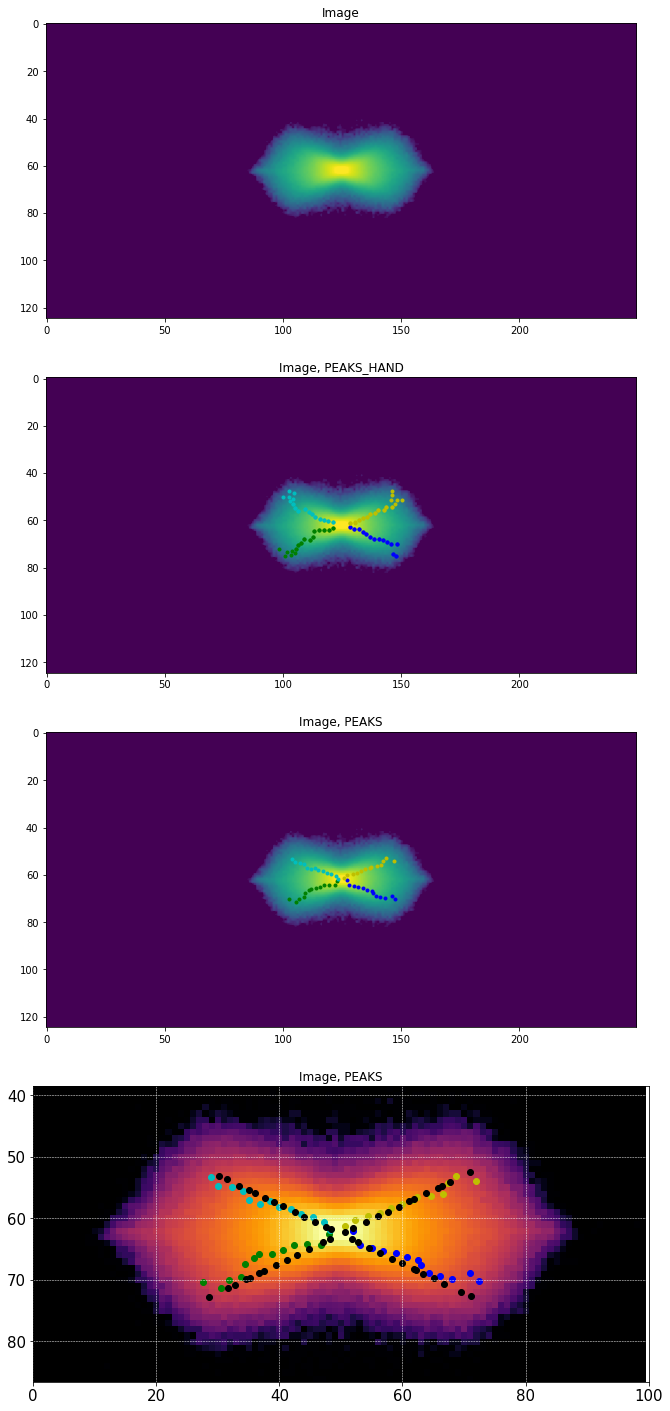

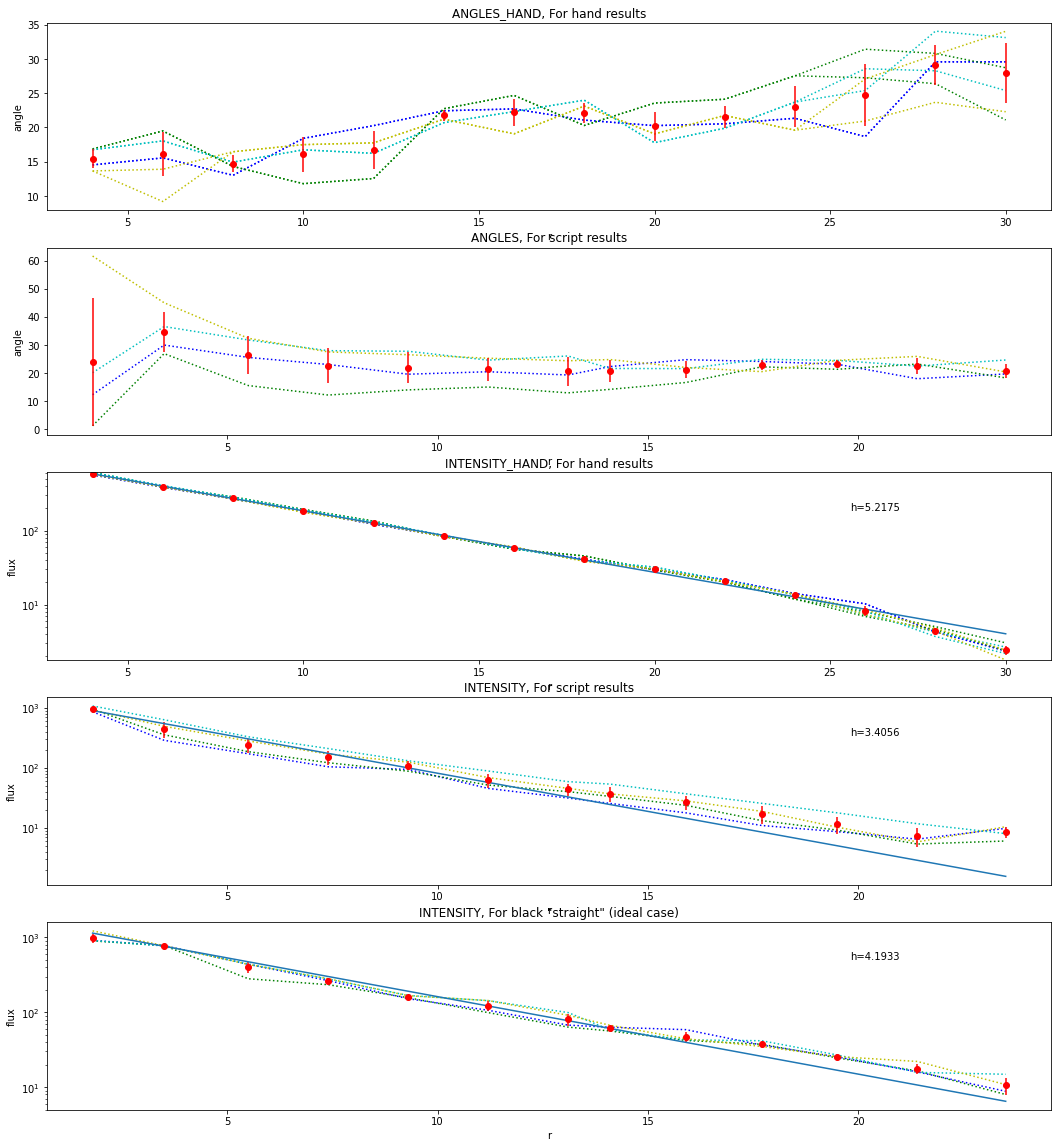

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Mh , ellipticity = 0.400000


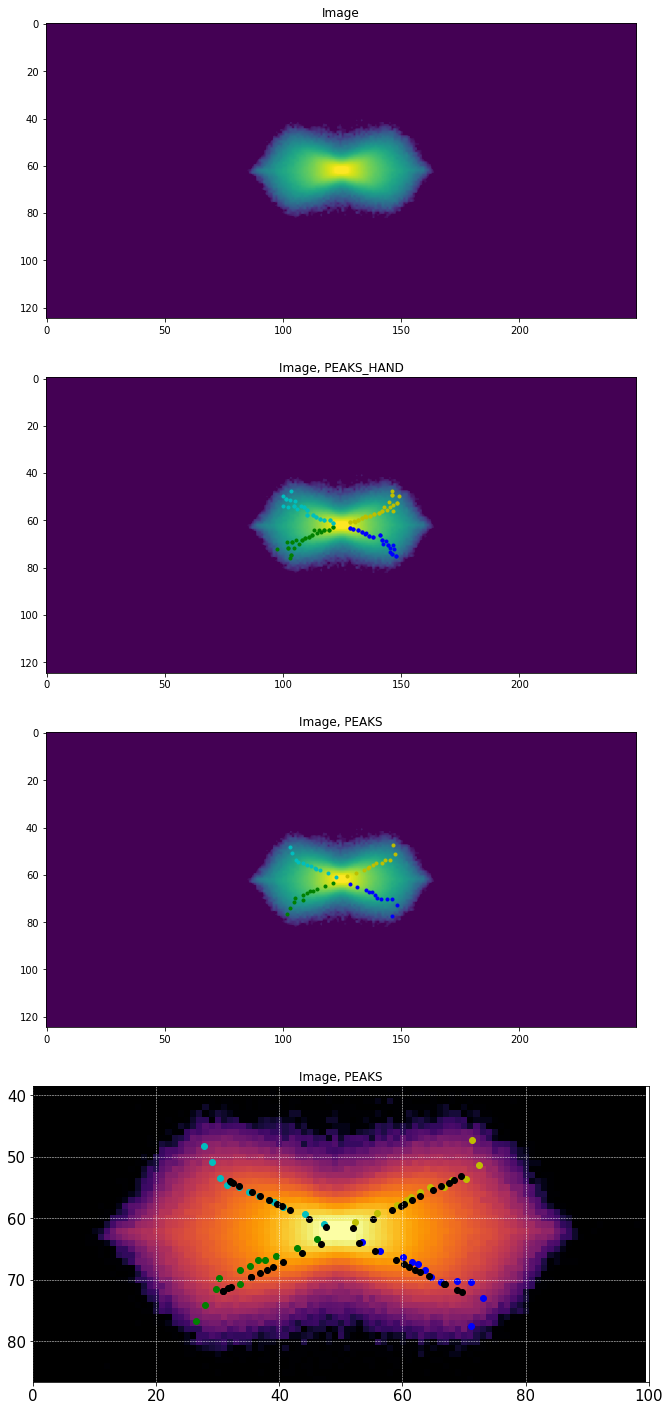

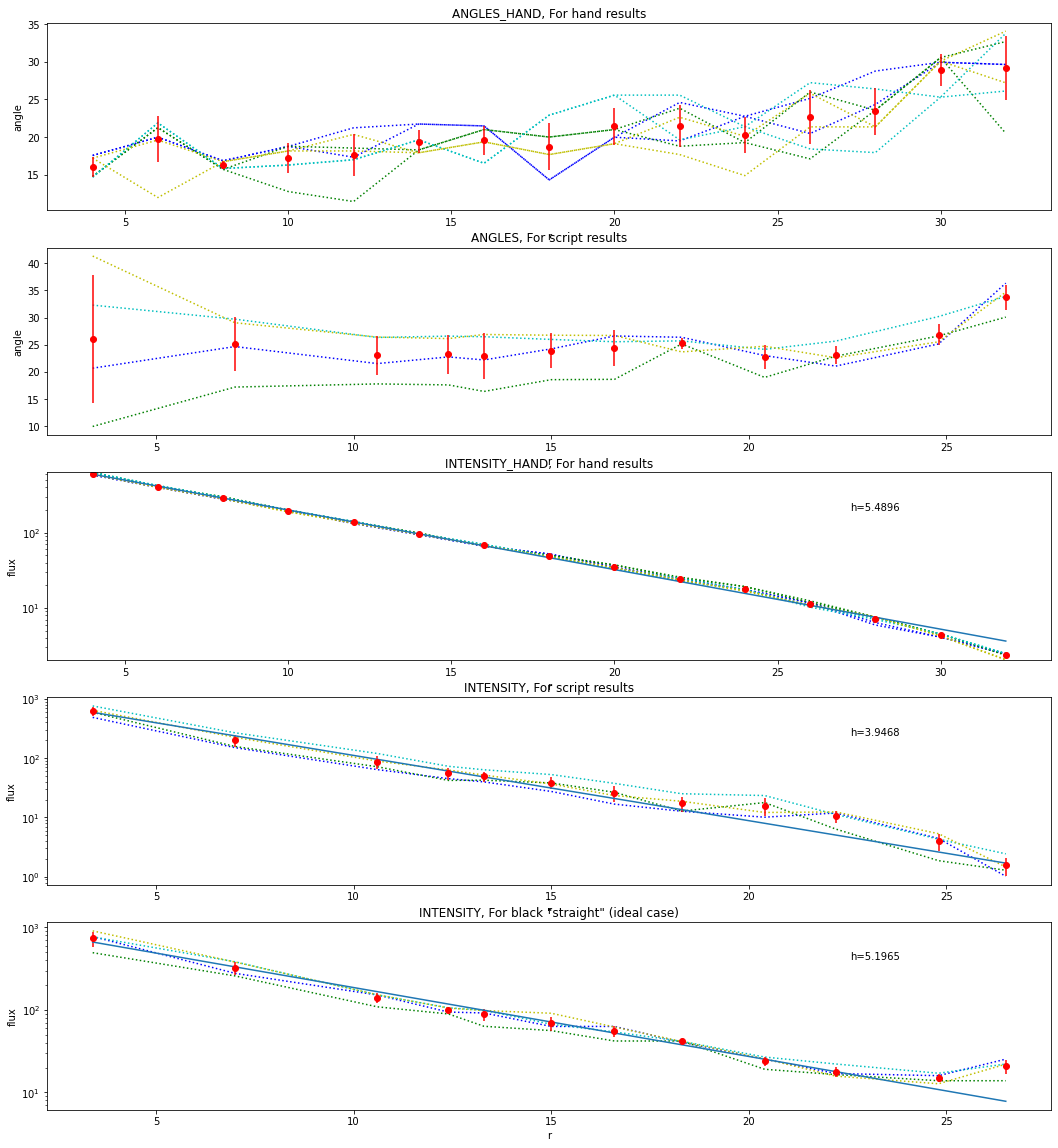

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Mh , ellipticity = 0.500000


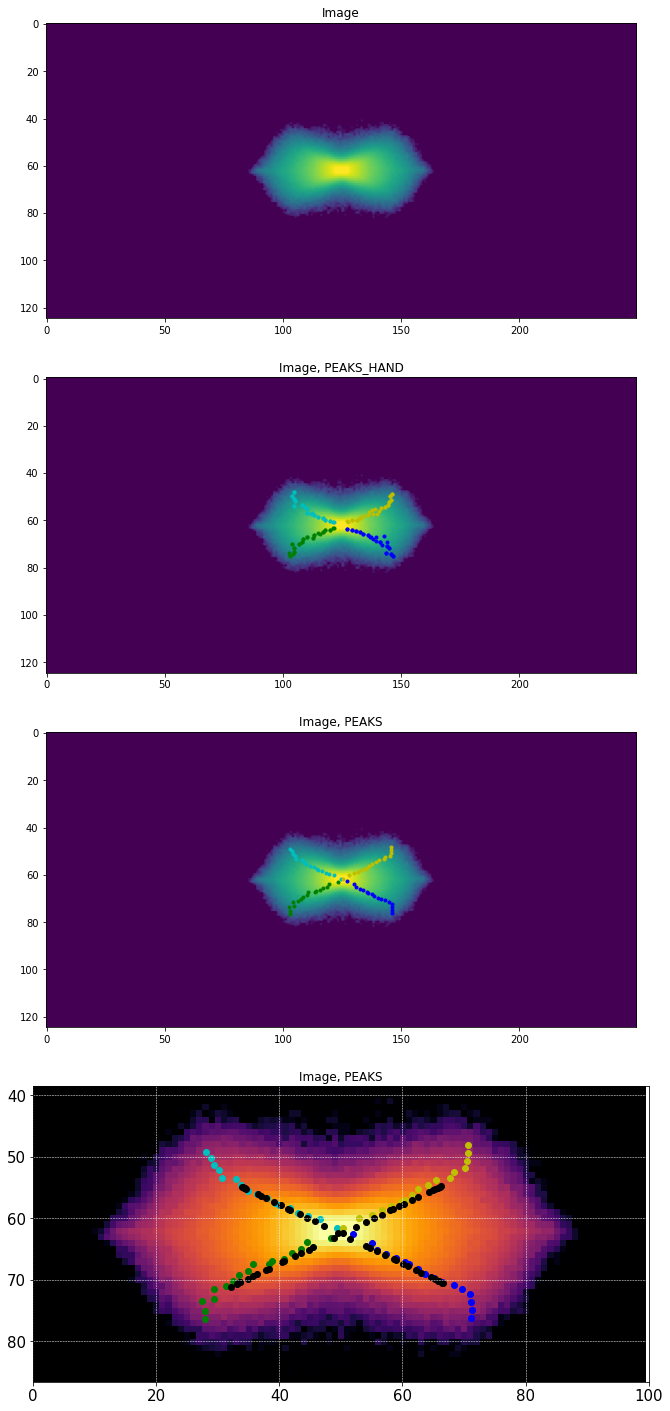

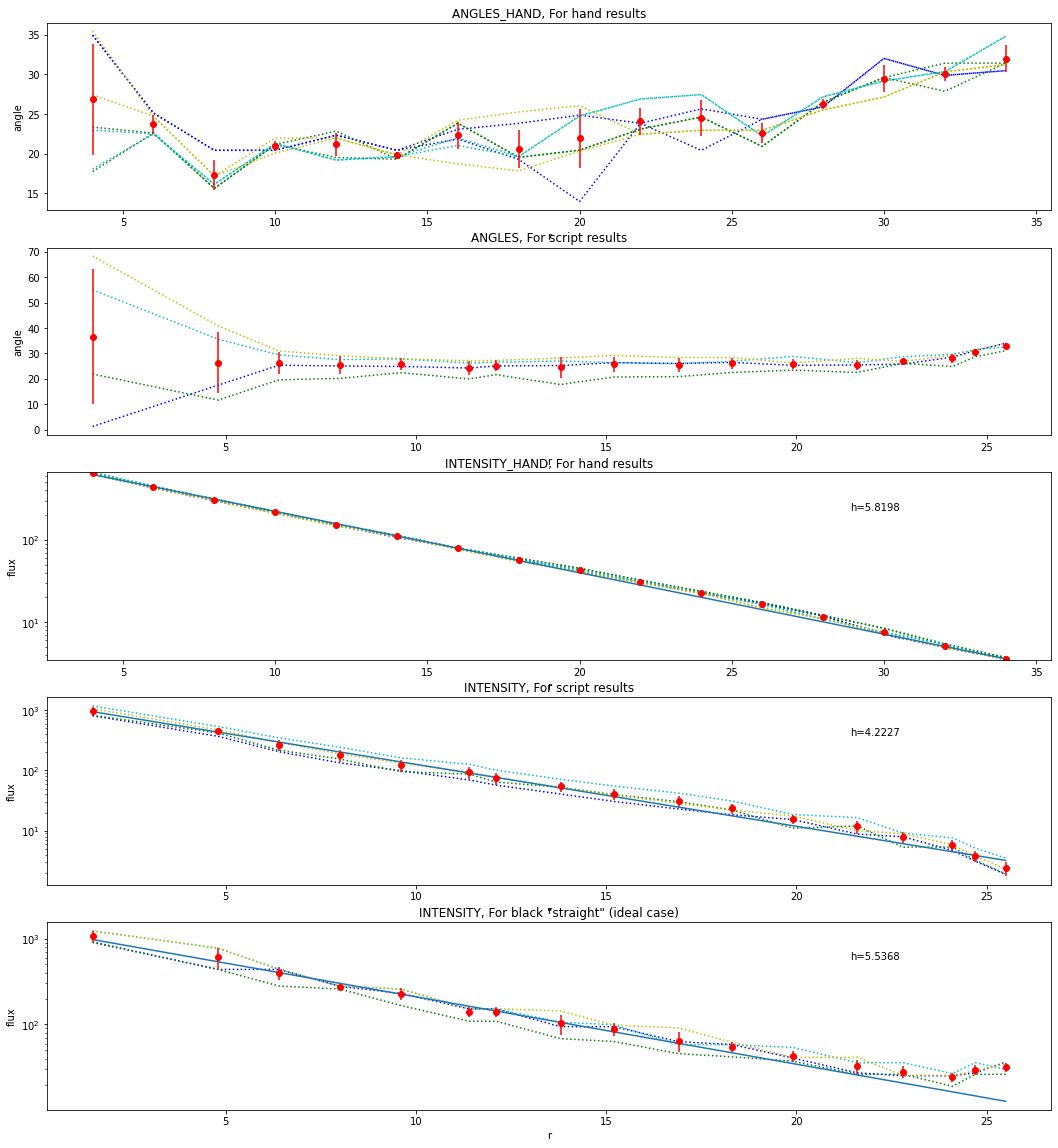

In [27]:
colors = ["b", "g", "c", "y"]
colors_hand = ["b", "b", "g", "g", "c", "c", "y", "y"]
my_cmap = copy.copy(matplotlib.cm.get_cmap('inferno'))  # copy the default cmap
my_cmap.set_bad((0, 0, 0))
for i in range(0,len(names)):
    name_gal = 'Mh' #names[i][0]
    name_gal_test = names[i][0]
    if names[i][4] == 5:
        path_raw_image = './images/image_{}.fits'.format(name_gal)
        hdulist_raw_image  = fits.open(path_raw_image)
        data_raw_image = hdulist_raw_image[0].data 
    
    path_image, path_angles, path_intens, path_coords, path_config = [], [], [], [], []
    path_angles_hand, path_intens_hand, path_coords_hand = [], [], []
    radii_hand, angles_hand, intens_hand, coords_hand = [], [], [], []
    data_image, radii, angles_1, intens_1, coords_1, xcen, ycen, axis_ratio = [], [], [], [], [], [], [], []
    data_intens, angles_2, intens_2, coords_2 = [], [], [], []
    ind_2 = [ [[],[],[],[]] , [[],[],[],[]] ]
    #for i_d_m, d_m in [[0,'d'],[1,'m']]:
    path_image0 = './images/image_{}.fits'.format(name_gal) 
    path_image.append(path_image0) 
    
    path_angles_hand0 = './result/{}/angles_hand.dat'.format(name_gal_test)
    path_intens_hand0 = './result/{}/intensities_hand.dat'.format(name_gal_test)
    path_coords_hand0 = './result/{}/coord_xy_peaks_hand.dat'.format(name_gal_test)
    if names[i][11] == 'old':
        path_angles0 = './result/{}/angles.dat'.format(name_gal_test)
        path_intens0 = './result/{}/intensities.dat'.format(name_gal_test)
        path_coords0 = './result/{}/coord_xy_peaks.dat'.format(name_gal_test)
    if names[i][11] == 'new':
        path_angles0 = './result/{}/angles_clean.dat'.format(name_gal_test)
        path_intens0 = './result/{}/intensities_clean.dat'.format(name_gal_test)
        path_coords0 = './result/{}/coord_xy_peaks_clean.dat'.format(name_gal_test)
                
    path_angles.append(path_angles0)     
    path_intens.append(path_intens0)       
    path_coords.append(path_coords0)
    path_angles_hand.append(path_angles_hand0)     
    path_intens_hand.append(path_intens_hand0)       
    path_coords_hand.append(path_coords_hand0)
        
    path_config0 = './configs/config_{}.dat'.format(name_gal_test)
    path_config.append(path_config0)

    hdulist_image  = fits.open(path_image[0])
    data_image0 = hdulist_image[0].data 
    data_image.append(data_image0)
                                              
    # Первый набор данных -- координаты, углы и интенсивности для точек, получаемые программой.
    # У каждой галактики эти данные записаны в файлах coord_xy_peaks.dat, angles.dat, intensities.dat.
        
    radii0 = np.loadtxt(path_angles[0], usecols=[0], comments='#') 
    radii.append(radii0)                                  
    angles_10 = np.loadtxt(path_angles[0], usecols=np.arange(1,7), comments='#')  
    angles_1.append(angles_10)
    intens_10 = np.loadtxt(path_intens[0], usecols=np.arange(1,7), comments='#') 
    intens_1.append(intens_10)
    coords_10 = np.loadtxt(path_coords[0], usecols=np.arange(1,9), comments='#') 
    coords_1.append(coords_10)
        
    radii_hand0 = np.loadtxt(path_angles_hand[0], usecols=[0], comments='#') 
    radii_hand.append(radii_hand0) 
    angles_hand0 = np.loadtxt(path_angles_hand[0], usecols=np.arange(1,11), comments='#')  
    angles_hand.append(angles_hand0)
    intens_hand0 = np.loadtxt(path_intens_hand[0], usecols=np.arange(1,11), comments='#') 
    intens_hand.append(intens_hand0)
    coords_hand0 = np.loadtxt(path_coords_hand[0], usecols=np.arange(1,17), comments='#') 
    coords_hand.append(coords_hand0)        
    
    # Второй набор тех же данных, но для чёрной "прямой", состоящей из чёрных точек. 
            
            # Найдём координаты центра изображения и эллиптичность эллипсов
    with open(path_config[0]) as file:
        for line in file:
            if line.find('x_center:') != -1:
                xcen0 = float(line.split()[1])
                xcen.append(xcen0)
            if line.find('y_center:') != -1:
                ycen0 = float(line.split()[1])
                ycen.append(ycen0)
            if line.find('ell_ellipticity:') != -1:
                ell = float(line.split()[1])
    ell_l = []
    ell_l.append(ell)
    axis_ratio0 = np.ones(len(ell_l)) - ell_l 
    axis_ratio.append(axis_ratio0)
    signs_xy = ((1,1),(-1,1),(-1,-1),(1,-1),)
    x0 = names[i][1]
    y0 = ycen[0]   
    k_ideal = names[i][3] 
    ang = 1
        
    data_intens0 = data_image[0][:,int(xcen[0]-names[i][1]):int(xcen[0]+names[i][1])]
    data_intens.append(data_intens0)
    
    angles_20 = np.zeros((radii[0].size,6))
    angles_2.append(angles_20)
    coords_20 = np.zeros((radii[0].size,8))
    coords_2.append(coords_20)
    intens_20 = np.zeros((radii[0].size,6))
    intens_2.append(intens_20)
    angles_2[0][:, 0:4] = np.tan(angles_1[0][:, 0:4]*np.pi/180)
    for j in range (1,5): 
        x = radii[0]/np.sqrt(1 + angles_2[0][:,j-1]**2/axis_ratio[0][0]**2)
        y = angles_2[0][:,j-1]*x
        x_ideal = np.copy(x)
        y_ideal = x_ideal*k_ideal
        x, y = rotate_via_numpy(x, y, np.pi/180.0*ang)
        x_ideal, y_ideal = rotate_via_numpy(x_ideal, y_ideal, np.pi/180.0*ang)
        x_ideal = x0 + signs_xy[j-1][0]*x_ideal
        y_ideal = y0 + signs_xy[j-1][1]*y_ideal  
        x = x0 + signs_xy[j-1][0]*x
        y = y0 + signs_xy[j-1][1]*y
        coords_2[0][:,j-1], coords_2[0][:,j+3] = np.transpose(x_ideal), np.transpose(y_ideal)
        
    for jj1 in range (1,5):
        for jj in range(len(x_ideal)):
            intens_2[0][jj,jj1-1] = data_intens[0][int(coords_2[0][jj,jj1+3])][int(coords_2[0][jj,jj1-1])]
            if intens_2[0][jj,jj1-1] < 0:
                intens_2[0][jj,jj1-1] = None
                ind_2[0][jj1-1].append(jj)
    angles_2[0][:,0:4] = np.arctan(k_ideal)*180/pi 
        
    for jj in range(len(x_ideal)):
        for_intens = [intf for intf in intens_2[0][jj,0:4] if intf != None and intf > 0.0]
        for_angles = []
        for iii in range(0,4):
            if intens_2[0][jj,iii] != None:
                for_angles.append(angles_2[0][jj,iii])
        intens_2[0][jj,4] = np.average(for_intens) 
        intens_2[0][jj,5] = np.std(for_intens) 
        angles_2[0][jj,4] = np.average(for_angles) 
        angles_2[0][jj,5] = np.std(for_angles)
        
        # Построение рисунков ====================================================
        
    print('=*'*50)
    print("%s , ellipticity = %f" % (name_gal, 0.3 + i*0.1))
                                     
    fig = plt.figure(figsize=[names[i][7],names[i][8]])   
    i_dop = 1
    if names[i][4] == 5:
        plt.subplot(names[i][4], 1, 1)
        plt.imshow(data_raw_image, norm=SymLogNorm(linthresh=names[i][5],vmin=0.005,vmax=names[i][6]))
        plt.title('Raw image')
        i_dop = 3    
    i_d_m = 0
    for i_subplot in range(names[i][4]):        
        if i_subplot < 3:
            plt.subplot(names[i][4],1,i_subplot+i_dop)
            plt.imshow(data_image[i_d_m],norm=SymLogNorm(linthresh=0.001,vmin=names[i][5],vmax=names[i][6]))
            if i_subplot == 1:
                for lobe_number in range(0, 8):
                    xf = [xc for xc in coords_hand[i_d_m][:,lobe_number] if xc != -1.0]
                    yf = [xc for xc in coords_hand[i_d_m][:,lobe_number+8] if xc != -1.0]
                    plt.plot(xf, yf, color=colors_hand[lobe_number],  marker='o', linestyle="", markersize=3.0)
            if i_subplot == 2:
                for lobe_number in range(0, 4):
                    xf = [xc for xc in coords_1[i_d_m][:,lobe_number] if xc != -1.0]
                    yf = [xc for xc in coords_1[i_d_m][:,lobe_number+4] if xc != -1.0]
                    plt.plot(xf, yf, color=colors[lobe_number],  marker='o', linestyle="", markersize=3.0)
            plt.title(titles_1[i_subplot])
        if i_subplot == 3:
            plt.subplot(names[i][4],1,i_subplot+i_dop)
            plt.imshow(data_image[i_d_m][:,int(xcen[i_d_m]-names[i][1]):int(xcen[i_d_m]+names[i][1])], 
                       cmap=my_cmap, origin="lower", norm=LogNorm(vmin=names[i][5], vmax=names[i][6]))
            plt.grid(color='w', linestyle='--', linewidth=0.5)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            for lobe_number in range(0, 4):
                xx = [xc for xc in coords_1[i_d_m][:,lobe_number] if xc != -1.0]
                yy = [xc for xc in coords_1[i_d_m][:,lobe_number+4] if xc != -1.0]
                x2 = [xc for xc in coords_2[i_d_m][:,lobe_number] if xc != -1.0]
                y2 = [xc for xc in coords_2[i_d_m][:,lobe_number+4] if xc != -1.0]
                # bbb = [x01+1 for x01 in aaa]
                xx = [z+names[i][1]-xcen[i_d_m] for z in xx]
                #xx = names[i][1] - xcen[i_d_m]  + xx
                plt.scatter(xx, yy, color=colors[lobe_number])
                plt.scatter(x2, y2, color="k")
            plt.gca().set_aspect("equal")
            plt.xlim([-names[i][1]+names[i][1], names[i][1]+names[i][1]])
            plt.ylim([-names[i][2]+ycen[i_d_m], names[i][2]+ycen[i_d_m]])
            plt.gca().invert_yaxis()
            plt.title(titles_1[i_subplot])       
        #if i_d_m == 0:
        #    i_d_m = 1 
        #else:
        #    i_d_m = 0           
    plt.savefig("./result/{}_picture_peaks.png".format(name_gal_test),dpi=300, bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()
    
    fig = plt.figure(figsize=[names[i][9],names[i][10]])
    i_d_m = 0
    i_dm = 0
    intens = []
    intens.extend(intens_1)    
    intens.extend(intens_2) 
    for i_subplot in range(5*1):
        if i_subplot == 0:
            plt.subplot(5, 1, i_subplot+1)
            for lobe_number in range(0, 8):
                plt.plot(radii_hand[i_d_m], angles_hand[i_d_m][:,lobe_number], 
                         color=colors_hand[lobe_number], linestyle=":")
            plt.errorbar(x=radii_hand[i_d_m], y=angles_hand[i_d_m][:,8], yerr=angles_hand[i_d_m][:,9], fmt="ro")
            plt.xlabel("r")
            plt.ylabel("angle")
            plt.title(titles_2[i_subplot])        
        if i_subplot == 1:
            plt.subplot(5, 1, i_subplot+1)
            for lobe_number in range(0, 4):
                radiif = []
                anglesf = []
                for ii in range(len(radii[i_d_m])):
                    if angles_1[i_d_m][ii,lobe_number] != -1:
                        radiif.append(radii[i_d_m][ii])
                        anglesf.append(angles_1[i_d_m][ii,lobe_number]) 
                plt.plot(radiif, anglesf, color=colors[lobe_number], linestyle=":")
            plt.errorbar(x=radii[i_d_m], y=angles_1[i_d_m][:,4], yerr=angles_1[i_d_m][:,5], fmt="ro")
            plt.xlabel("r")
            plt.ylabel("angle")
            plt.title(titles_2[i_subplot])
        if i_subplot == 2:
            plt.subplot(5, 1, i_subplot+1)
            central_value, exp_scale = fit_by_explaw(radii_hand[i_d_m], intens_hand[i_d_m][:,8], intens_hand[i_d_m][:,9])
            list_maxs, list_mins = [],[]
            for lobe_number in range(0, 8):
                plt.plot(radii_hand[i_d_m], intens_hand[i_d_m][:,lobe_number],
                         color=colors_hand[lobe_number], linestyle=":")
                list_maxs.append(max(intens_hand[i_d_m][:,lobe_number]))
                list_mins.append(min(intens_hand[i_d_m][:,lobe_number]))
            plt.errorbar(x=radii_hand[i_d_m], y=intens_hand[i_d_m][:,8], yerr=intens_hand[i_d_m][:,9], fmt="ro")
            plt.plot(radii_hand[i_d_m], explaw([central_value, exp_scale], radii_hand[i_d_m]), linestyle="solid")
            plt.annotate(text="h=%1.4f" % exp_scale, xy=(0.8, 0.8), xycoords="axes fraction")
            plt.xlabel("r")
            plt.ylabel("flux")
            plt.yscale('log')
            plt.ylim([min(list_mins),max(list_maxs)])
            plt.title(titles_2[i_subplot])
        if i_subplot > 2:
            plt.subplot(5, 1, i_subplot+1)
            central_value, exp_scale = fit_by_explaw(radii[i_d_m], intens[i_dm][:,4], intens[i_dm][:,5])
            for lobe_number in range(0, 4):
                radiif = []
                intensf = []
                for ii in range(len(radii[i_d_m])):
                    if intens[i_dm][ii,lobe_number] != -1 and intens[i_dm][ii,lobe_number] > 0.0:
                        radiif.append(radii[i_d_m][ii])
                        intensf.append(intens[i_dm][ii,lobe_number])                      
                plt.plot(radiif, intensf, color=colors[lobe_number], linestyle=":")
            plt.errorbar(x=radii[i_d_m], y=intens[i_dm][:,4], yerr=intens[i_dm][:,5], fmt="ro")
            plt.plot(radii[i_d_m], explaw([central_value, exp_scale], radii[i_d_m]), linestyle="solid")
            plt.annotate(text="h=%1.4f" % exp_scale, xy=(0.8, 0.8), xycoords="axes fraction")
            plt.xlabel("r")
            plt.ylabel("flux")
            plt.yscale('log')
            plt.title(titles_2[i_subplot])            
            i_dm += 1                        
      #  if i_d_m == 0:
      #      i_d_m = 1 
      #  else:
      #      i_d_m = 0
    plt.savefig("./result/{}_graphs.png".format(name_gal_test),dpi=300, bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()